# Tutorial: End-to-End Machine Learning Project

### The 8 main steps you will go through
1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for machine learning algorithms
5. Select a model and train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor, and maintain your system

## 1) Look at the Big Picture

### Frame the problem
- What exactly is the business objective?
- How will the company use and benefit from this model?

**This choice determines**
- how you frame the problem,
- which algorithms you try,
- which performance measure you use,
- how much effort to spend on tuning.

**What does the current solution look like (if any)?**
- It gives you a reference (baseline) performance,
- and offers insights into how the problem is solved today.

**Q: What exactly is the business objective?**  
**A:** Build a model using California census data that predicts the **median housing price** for any district given its other metrics.

**Q: How will the company use and benefit from this model?**  
**A:** The prediction becomes one of several signals to a downstream ML system that decides **whether to invest in a given area**—a decision that directly impacts revenue.

**Q: What does the current solution look like (if any)?**  
**A:** Prices are **estimated manually by experts** using complex rules; it’s costly, slow, and often **off by >10%**, motivating a learned predictor using the census data.

## Once we have all the answers then we can go for next set of questions.

## 1.1 Design the System — Questions

**A) Frame the learning problem**
- Is it supervised, unsupervised, or reinforcement learning?
- Is it classification, regression, or something else?
- Will you use batch learning or online learning? Why?

**B) Define objective & role in the pipeline**
- What exactly is the model’s output, and how will a downstream system use it?
- What will your data pipeline look like (components, interfaces)? Will components run asynchronously, and how will you monitor failures/staleness?

**C) Choose the performance measure**
- What primary metric will you use (e.g., RMSE)? Why?
- If there are many outliers, would MAE be preferable?

**D) Check critical assumptions**
- Does the downstream system need numeric prices or categories? If categories, should you reframe as classification?

**E) Create a reliable test set**
- How will you create the test set (pure random split vs. stratified sampling)?
- If stratifying by income, how will you build income categories and perform the split?
- Will you remove the helper stratification attribute after splitting?

## 2. Get the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

In [2]:
HOUSING_PATH = str(os.getcwd() + "/data")

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    """
    Load 'housing.csv' from the given directory.

    Parameters:
        housing_path (str): Path to the directory containing 'housing.csv'.

    Returns:
        pd.DataFrame: The housing data.
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File not found: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully: {csv_path}")
    return df

In [4]:
housing = load_housing_data()
housing.head()

Data loaded successfully: /Volumes/DataBank1/00-DataBank/GitHub/DataScience/ML_Tutorials/Tutorial1_HousingPricePrediction/data/housing.csv


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
# List of attributes in the dataset.
housing_attributes = housing.columns.tolist()
print ("Total number of attributes: ", len(housing_attributes))
print("Attributes in the dataset:", housing_attributes)

Total number of attributes:  10
Attributes in the dataset: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [6]:
# Total number of intances in the dataset.
total_instances = len(housing)
print(f"\nTotal number of instances in the dataset: {total_instances}")


Total number of instances in the dataset: 20640


In [7]:
# Quick description of the dataset.
print("\nDataset Description:")
print (housing.info())


Dataset Description:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [8]:
# Count how many attributes are numeric and how many are categorical.
numeric_attributes = housing.select_dtypes(include=[np.number]).columns.tolist()
categorical_attributes = housing.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumber of numeric attributes: {len(numeric_attributes)}")
print("Numeric attributes:", numeric_attributes)

print(f"\nNumber of categorical attributes: {len(categorical_attributes)}")
print("Categorical attributes:", categorical_attributes)


Number of numeric attributes: 9
Numeric attributes: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

Number of categorical attributes: 1
Categorical attributes: ['ocean_proximity']


### We found ```ocean_proximity``` is a categorical attribute. Next, it is better if we find all the distinct categories in this attribute.

In [9]:
# Count all the distinct categories in the categorical attributes.
# Here we will create a dictionary to hold the counts of each categorical attribute.
categorical_attributes_data = {}
for cat in categorical_attributes:
    counts = housing[cat].value_counts(dropna=False)
    categorical_attributes_data[cat] = counts
categorical_attributes_data

{'ocean_proximity': ocean_proximity
 <1H OCEAN     9136
 INLAND        6551
 NEAR OCEAN    2658
 NEAR BAY      2290
 ISLAND           5
 Name: count, dtype: int64}

In [10]:
# Lets get the summary of the numeric attributes.
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

#### It looks like "total_bedrooms" has some missing values. Instead of 20640 counts it has 20433 counts. Threfore, we have to properly handle these missing values.

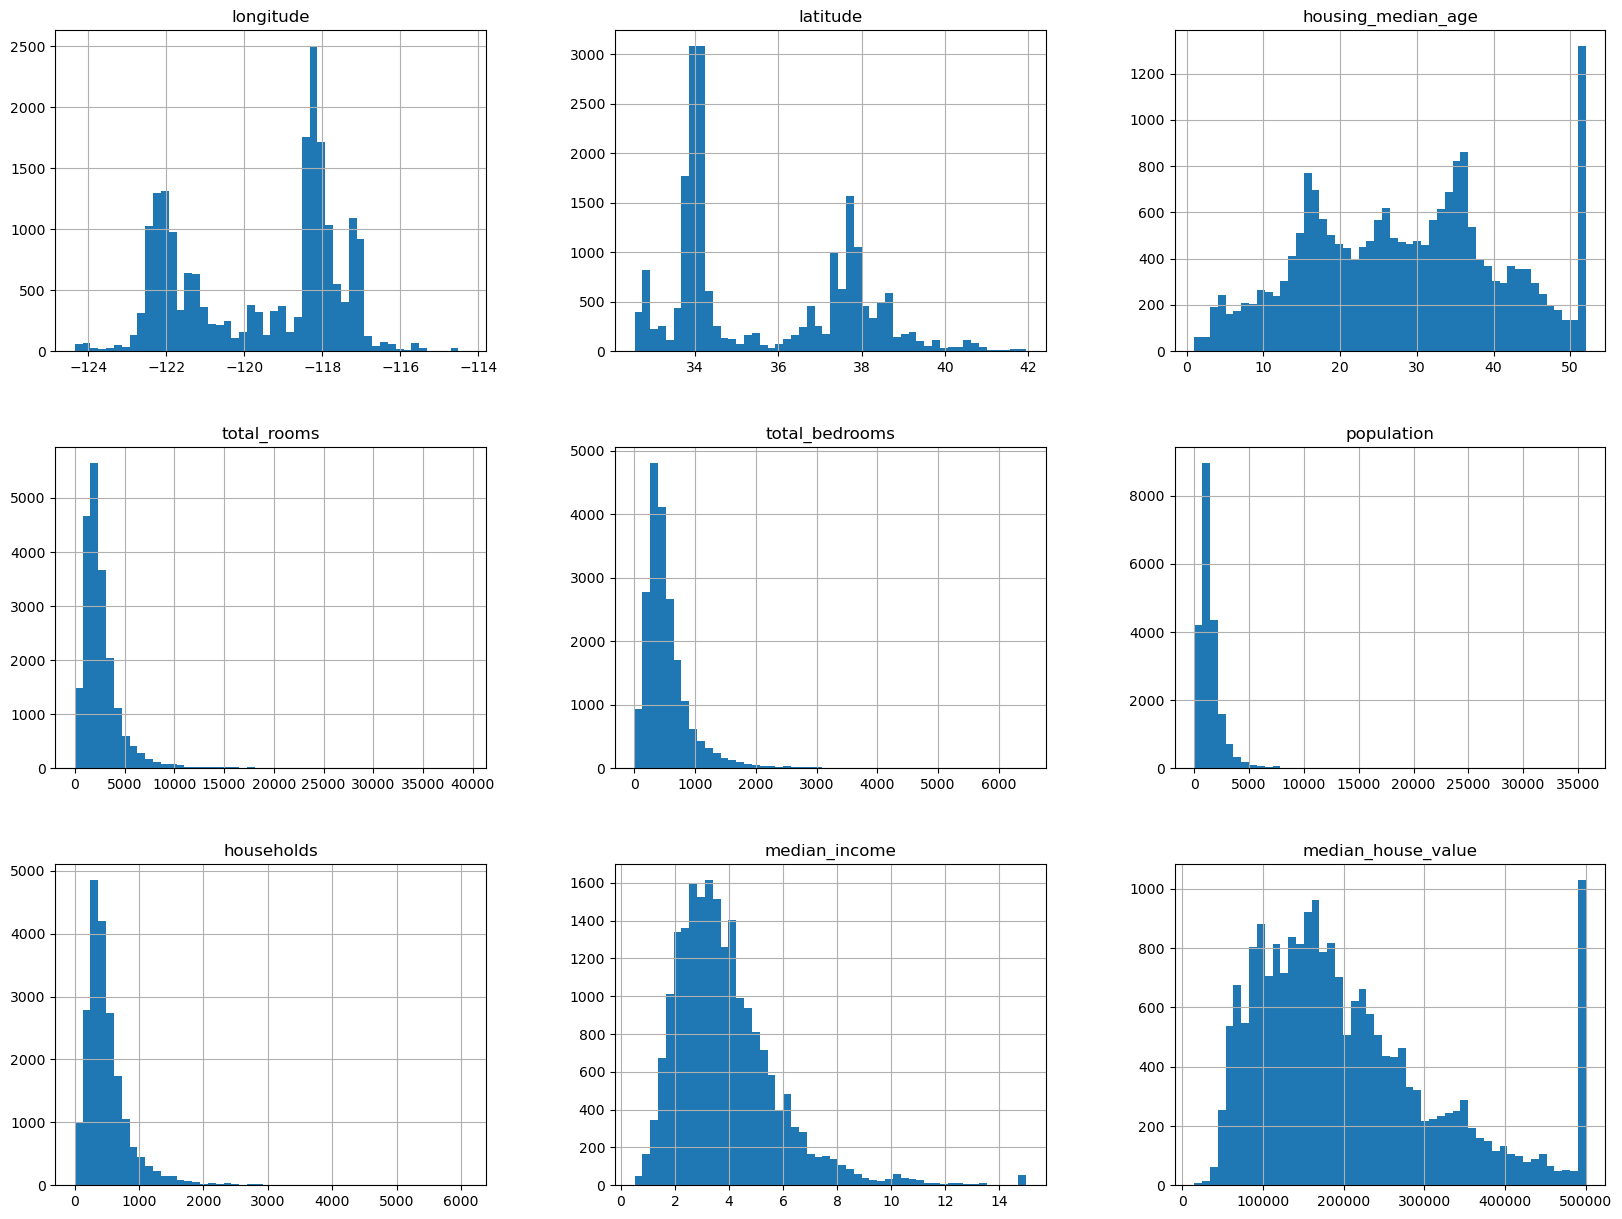

In [11]:
# Lets visualze the numarical data using histogram plot. This plot shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis).
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### Insights from histogram plot.
1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the
data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes.
2. The housing median age and the median house value were also capped.
3. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns.

## Create Test Set

#### Creating test set in early stage avoid the **data snooping** bias

Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside.

In [12]:
# Toy model to split the dataset into training and test sets. But this is not the best way to do it because if you run the program multiple times, 
# you will get different training and test sets each time. This is not ideal for reproducibility.
def split_train_test(data, test_ratio):
    """
    Split the dataset into training and test sets.

    Parameters:
        data (pd.DataFrame): The dataset to split.
        test_ratio (float): The proportion of the dataset to include in the test set.

    Returns:
        tuple: Training set and test set as DataFrames.
    """
    np.random.seed(42)                                          # Set a random seed for reproducibility.
    shuffled_indices = np.random.permutation(len(data))         # Create a randomized ordering of row indices to remove any ordering bias.
    test_set_size = int(len(data) * test_ratio)                 # Compute how many rows should go into the test set.
    test_indices = shuffled_indices[:test_set_size]             # Take the first slice of shuffled indices as the test set.
    train_indices = shuffled_indices[test_set_size:]            # Use the remaining indices as the training set.

    return data.iloc[train_indices], data.iloc[test_indices]    # Return the two subsets using positional indexing with iloc.

In [13]:
# A common solution is to use each instance’s identifier to decide whether or not it should go 
# in the test set (assuming instances have a unique and immutable identifier).
# For example, you could compute a hash of each instance’s identifier, keep only the last 
# byte of the hash, and put the instance in the test set if this value is lower or equal to 51 (~20% of 256).

import hashlib

def test_set_check(identifier, test_ratio, hash):
    """
    Check if an instance should be part of the test set based on its identifier.

    Parameters:
        identifier (str): The identifier of the instance.
        test_ratio (float): The proportion of the dataset to include in the test set.

    Returns:
        bool: True if the instance should be in the test set, False otherwise.
    """
    identifier_bytes = str(identifier).encode("utf-8")      # Convert the identifier to bytes (works for both strings and numbers).
    hashed = hash(identifier_bytes).digest()                # Hash the bytes; md5 produces 16 bytes (values 0..255 at each position).
    last_byte = hashed[-1]                                  # Take the last byte (0..255) as a stable pseudo-random number.
    return last_byte < 256 * test_ratio                     # Send to test set if the last byte is below the test threshold (e.g., 256*0.2 = 51.2).

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    """
    Split the dataset into training and test sets based on an identifier column.

    Parameters:
        data (pd.DataFrame): The dataset to split.
        test_ratio (float): The proportion of the dataset to include in the test set.
        id_column (str): The name of the column containing unique identifiers.
        hash (function): Hash function to use for checking identifiers.

    Returns:
        tuple: Training set and test set as DataFrames.
    """
    ids = data[id_column]                                                       # Pull the identifier Series (must be stable and unique per instance).
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))  # Decide for each id whether it belongs to the test set (True/False).
    return data.loc[~in_test_set], data.loc[in_test_set]                        # Return the two views of the DataFrame using the boolean mask.

In [14]:
# We use row index as the unique identifier for each instance.
housing_with_id = housing.reset_index()  # Reset index to create a new column 'index' with unique identifiers.
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

# Make sure that new data gets appended to the end of the dataset, and no row ever gets deleted.

In [15]:
# More stable feature to build a unique identifier is to use a combination of features that are unlikely to change over time.
# For example, you could use a combination of the latitude and longitude coordinates, or a combination of the address and postal code.
# This way, even if the dataset is updated with new instances, the unique identifiers will remain stable.
# This is especially useful if you want to keep track of instances over time, such as in a time series analysis.
# You can create a new column in the DataFrame that combines these features to create a unique identifier for each instance.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]  # Example of creating a unique identifier using longitude and latitude.
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

### Scikit-learn have few inbuild functions to split the train and test data. ```train_test_split``` is the simplest function which is nothing but similar what we have in ```split_train_test```.

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)  # Using Scikit-learn's built-in function to split the dataset.

### We used random sampling method so far.
- which is fine for large dataset.
### Why stratified sampling here (and how to build `income_cat`)
- Purely random splits can **skew important attribute ratios** when the dataset isn’t huge → sampling bias in the test set.
- **Stratified sampling**: split the population into homogeneous **strata** (e.g., income bands) and sample **proportionally** from each stratum to keep the test set representative.
- In this problem, **median income** strongly influences housing prices, so we want train/test sets that **preserve its distribution**.
- Since median income is **continuous**, we first create **discrete income categories**:
  - `income_cat = ceil(median_income / 1.5)` → limits the number of bins.
  - Merge all categories **> 5** into **5** → avoids tiny, unreliable strata.
- After performing the **stratified split** using `income_cat`, **drop** the helper column to prevent leakage.

In [17]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)  # Create income categories by dividing median income into bands of 1.5.
housing["income_cat"].where(housing["income_cat"] < 5, 5.0)  # Cap the maximum income category to 5.

0        5.0
1        5.0
2        5.0
3        4.0
4        3.0
        ... 
20635    2.0
20636    2.0
20637    2.0
20638    2.0
20639    2.0
Name: income_cat, Length: 20640, dtype: float64

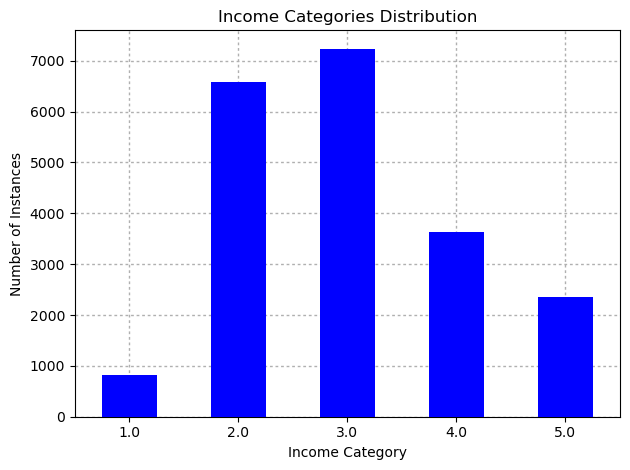

In [18]:
# Visukalize the income categories cap to 5.
ax = (housing["income_cat"]
        .where(housing["income_cat"] < 5, 5.0)
        .value_counts()
        .sort_index()
        .plot(kind="bar", title="Income Categories Distribution", zorder=3, color='blue'))

ax.set_xlabel("Income Category")
ax.set_ylabel("Number of Instances")
ax.set_axisbelow(True)
ax.grid(True, linestyle=(0, (2, 2)), linewidth=1, alpha=1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Stratified Sampling based on income category.

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3.0     0.350533
2.0     0.318798
4.0     0.176357
5.0     0.069041
1.0     0.039729
6.0     0.025678
7.0     0.009205
8.0     0.005087
11.0    0.002422
9.0     0.002422
10.0    0.000727
Name: count, dtype: float64

In [21]:
# Sampling bias comparision of stratified versus purely random sampling.
def income_cat_proportions(df):
    return (df["income_cat"]
            .value_counts(normalize=True)
            .sort_index())

# Random split (baseline)
rand_train_set, rand_test_set = train_test_split(housing, test_size=0.2, random_state=42)

overall_prop   = income_cat_proportions(housing)
random_prop    = income_cat_proportions(rand_test_set)
stratified_prop= income_cat_proportions(strat_test_set)

# Assemble comparison table
compare = pd.DataFrame({
    "Overall": overall_prop,
    "Random Test": random_prop,
    "Stratified Test": stratified_prop
})


In [22]:
compare

Overall  Random Test  Stratified Test
income_cat                                        
1.0         0.039826     0.040213         0.039729
2.0         0.318847     0.324370         0.318798
3.0         0.350581     0.358527         0.350533
4.0         0.176308     0.167393         0.176357
5.0         0.068944     0.064922         0.069041
6.0         0.025775     0.024709         0.025678
7.0         0.009157     0.008721         0.009205
8.0         0.005087     0.005572         0.005087
9.0         0.002422     0.002665         0.002422
10.0        0.000678     0.000969         0.000727
11.0        0.002374     0.001938         0.002422

In [23]:
compare["Rand. % error"] = (compare["Random Test"] - compare["Overall"]) / compare["Overall"] * 100
compare["Strat. % error"] = (compare["Stratified Test"] - compare["Overall"]) / compare["Overall"] * 100

In [24]:
compare

Overall  Random Test  Stratified Test  Rand. % error  \
income_cat                                                          
1.0         0.039826     0.040213         0.039729       0.973236   
2.0         0.318847     0.324370         0.318798       1.732260   
3.0         0.350581     0.358527         0.350533       2.266446   
4.0         0.176308     0.167393         0.176357      -5.056334   
5.0         0.068944     0.064922         0.069041      -5.832748   
6.0         0.025775     0.024709         0.025678      -4.135338   
7.0         0.009157     0.008721         0.009205      -4.761905   
8.0         0.005087     0.005572         0.005087       9.523810   
9.0         0.002422     0.002665         0.002422      10.000000   
10.0        0.000678     0.000969         0.000727      42.857143   
11.0        0.002374     0.001938         0.002422     -18.367347   

            Strat. % error  
income_cat                  
1.0              -0.243309  
2.0              -0.015195  
3.0              -0.013820  
4.0               0.027480  
5.0               0.140548  
6.0              -0.375940  
7.0               0.529101  
8.0               0.000000  
9.0               0.000000  
10.0              7.142857  
11.0              2.040816

In [25]:
strat_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [26]:
strat_test_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [28]:
strat_train_set.columns == strat_test_set.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## 3. Discover and Visualize the Data to gain insights

In [29]:
# Create a copy of the training dataset
housing_train = strat_train_set.copy()

### Visulaize Geographical Data

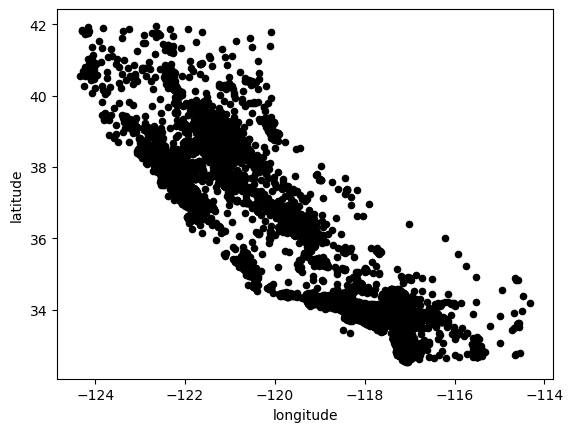

In [30]:
housing_train.plot(kind = 'scatter', x = 'longitude', y = 'latitude', color = 'black')
plt.show()

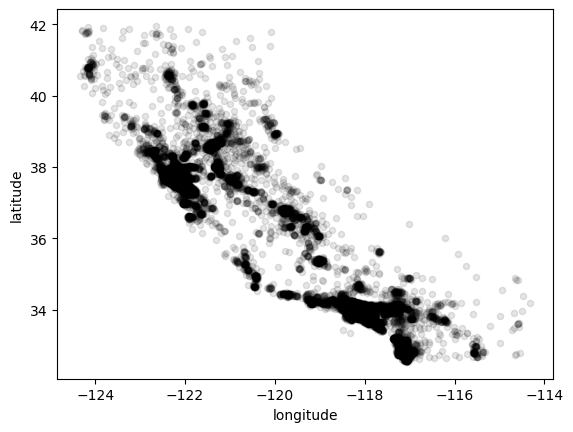

In [31]:
# apha = 0.1 to visualise highl;y dense areas.
housing_train.plot(kind = 'scatter', x = 'longitude', y = 'latitude', color = 'black', alpha = 0.1)
plt.show()

#### It looks like the California map.

### To get the more insight about the area we can use the map folium.

In [39]:
import folium
from folium.plugins import HeatMap

# Make a base map centered on the median lat/lon of your data
center = [housing_train["latitude"].median(), housing_train["longitude"].median()]
map = folium.Map(location=center, zoom_start=5, tiles="CartoDB positron")

# Add a heatmap layer (density of points)
heat_data = housing_train[["latitude", "longitude"]].values.tolist()
HeatMap(heat_data, radius=6, blur=5, min_opacity=0.2).add_to(map)

# To show the map
map

#### You can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

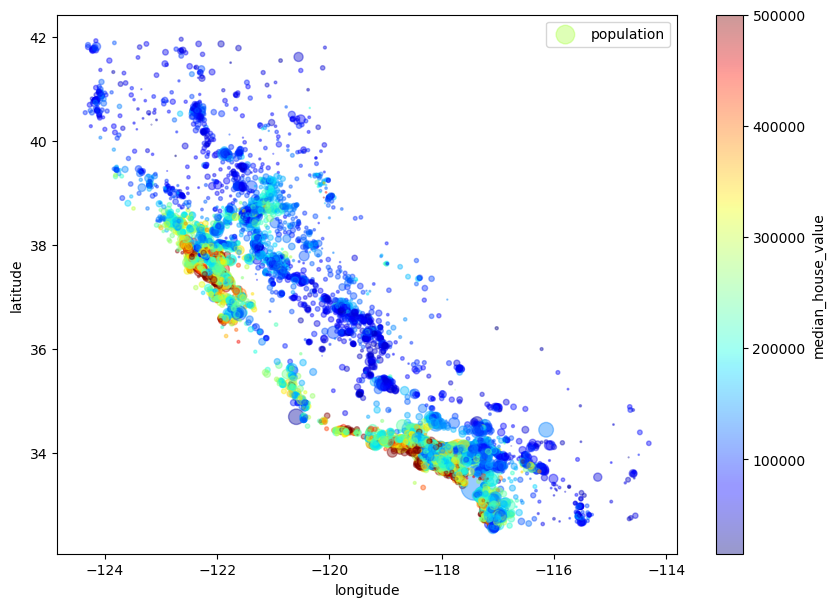

In [37]:
# To get more insight lets go back to our scatter plot.
housing_train.plot(kind = 'scatter',
                    x = 'longitude',
                    y = 'latitude',
                    alpha = 0.4,
                    s = housing_train['population']/100,
                    label = "population",
                    figsize = (10, 7),
                    c = "median_house_value",
                    cmap = plt.get_cmap("jet"),
                    colorbar = True
                  )
plt.legend()
plt.show()

In [40]:
# This code snippet is generated by ChatGPT 5
import branca.colormap as cm

map2 = folium.Map(location=center, zoom_start=5, tiles="CartoDB positron")

# Color map for median house value (mimics a cool→warm palette)
vmin, vmax = housing_train["median_house_value"].min(), housing_train["median_house_value"].max()
colormap = cm.LinearColormap(
    colors=["darkblue", "cyan", "yellow", "orange", "red"],
    vmin=vmin, vmax=vmax
).to_step(10)
colormap.caption = "Median house value"
colormap.add_to(map2)

# Size function (clip so markers aren’t too tiny/huge)
def scale_radius(pop):
    return float(np.clip(pop / 1000, 2, 20))  # adjust 1000 if you want larger/smaller bubbles

# Add point markers (sample if many points for performance)
sample = housing_train if len(housing_train) <= 5000 else housing_train.sample(5000, random_state=42)
for _, r in sample.iterrows():
    folium.CircleMarker(
        location=[r["latitude"], r["longitude"]],
        radius=scale_radius(r["population"]),
        fill=True,
        fill_opacity=0.4,
        color=None,
        fill_color=colormap(r["median_house_value"]),
        popup=folium.Popup(
            f"Value: ${r['median_house_value']:.0f}<br>"
            f"Population: {int(r['population'])}",
            max_width=250
        ),
    ).add_to(map2)

map2

#### We can see that now the housing prices are very much related to the location and to the population density.

### Correlations

#### Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method.

#### The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to zero mean that there is no linear correlation.

#### Figure: Standard correlation coefficient of various datasets (Source: [Wikipedia](https://en.wikipedia.org/wiki/Correlation))
![Image](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

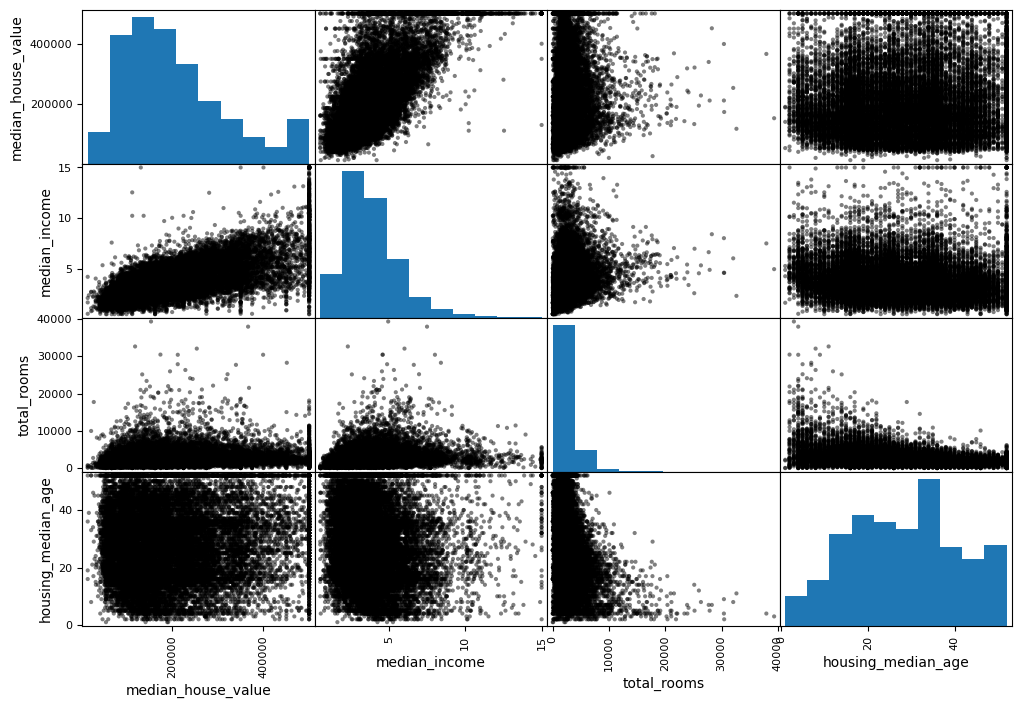

In [50]:
# We use pandas scatter matrix to study about correlation.
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8), color = "black")
plt.show()

#### The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

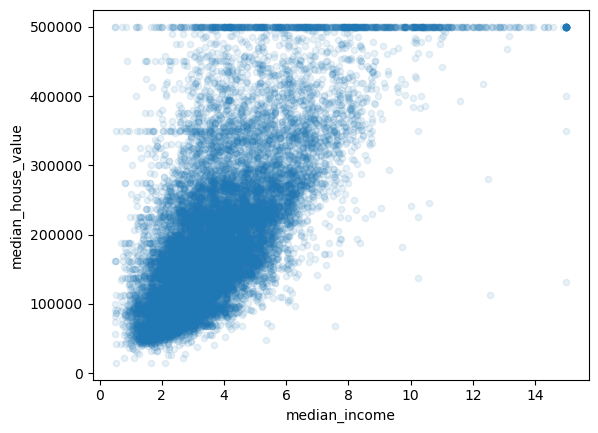

In [51]:
# Correlation of the median plot
housing_train.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)
plt.show()

#### Insights:
- Correlation is very strong (upward trend).
- Points are not too dispersed.
- Price cap at $500000.
- Plot reveals other less obvious straight lines: a horizontal line around $450,000, $350,000, $280,000, and few more below that.

### Conclusion till now:
- Found correlations between attributes.
- Identified few data quirks that need to be cleanup before feeding to ML algorithm.
- Some attributes have a tail-heavy distribution, need to be transform e.g. by computing their logarithm.
- One last thing need to be done before actually preparing the data fro ML algorithms is to try various combinations.

### Experiment with Attribute Combinations

- Total number of rooms in a district is not very useful, instead number of rooms per household.
- Similarly, total number of bedrooms by itself is not very useful, whereas compare it to the number of rooms.
- Likewise, population per household is an interesting attribute combination to look at.

In [52]:
housing_train["rooms_per_household"] = housing_train["total_rooms"] / housing_train["households"]
housing_train["bedrooms_per_room"] = housing_train["total_bedrooms"] / housing_train["total_rooms"]
housing_train["population_per_household"] = housing_train["population"] / housing_train["households"]

In [54]:
# Correlation matrix
corr_matrix = housing_train.corr(numeric_only=True)
corr_matrix

longitude  latitude  housing_median_age  \
longitude                  1.000000 -0.924515           -0.109796   
latitude                  -0.924515  1.000000            0.009864   
housing_median_age        -0.109796  0.009864            1.000000   
total_rooms                0.048963 -0.039721           -0.363195   
total_bedrooms             0.075583 -0.071816           -0.324448   
population                 0.107149 -0.115095           -0.297841   
households                 0.061549 -0.076752           -0.305708   
median_income             -0.015589 -0.078979           -0.116608   
median_house_value        -0.045056 -0.144684            0.111770   
rooms_per_household       -0.025422  0.105002           -0.148362   
bedrooms_per_room          0.092702 -0.114027            0.138415   
population_per_household  -0.000370  0.005354            0.015252   

                          total_rooms  total_bedrooms  population  households  \
longitude                    0.048963        0.075583    0.107149    0.061549   
latitude                    -0.039721       -0.071816   -0.115095   -0.076752   
housing_median_age          -0.363195       -0.324448   -0.297841   -0.305708   
total_rooms                  1.000000        0.928874    0.855803    0.917204   
total_bedrooms               0.928874        1.000000    0.876225    0.979599   
population                   0.855803        0.876225    1.000000    0.905172   
households                   0.917204        0.979599    0.905172    1.000000   
median_income                0.203718       -0.005800    0.007472    0.014929   
median_house_value           0.135989        0.049177   -0.024765    0.065841   
rooms_per_household          0.130379        0.003490   -0.072129   -0.081002   
bedrooms_per_room           -0.194665        0.083918    0.034053    0.064310   
population_per_household    -0.024531       -0.028301    0.075880   -0.027337   

                          median_income  median_house_value  \
longitude                     -0.015589           -0.045056   
latitude                      -0.078979           -0.144684   
housing_median_age            -0.116608            0.111770   
total_rooms                    0.203718            0.135989   
total_bedrooms                -0.005800            0.049177   
population                     0.007472           -0.024765   
households                     0.014929            0.065841   
median_income                  1.000000            0.687474   
median_house_value             0.687474            1.000000   
rooms_per_household            0.311307            0.145750   
bedrooms_per_room             -0.625484           -0.259679   
population_per_household       0.022166           -0.021844   

                          rooms_per_household  bedrooms_per_room  \
longitude                           -0.025422           0.092702   
latitude                             0.105002          -0.114027   
housing_median_age                  -0.148362           0.138415   
total_rooms                          0.130379          -0.194665   
total_bedrooms                       0.003490           0.083918   
population                          -0.072129           0.034053   
households                          -0.081002           0.064310   
median_income                        0.311307          -0.625484   
median_house_value                   0.145750          -0.259679   
rooms_per_household                  1.000000          -0.398273   
bedrooms_per_room                   -0.398273           1.000000   
population_per_household            -0.005247           0.004178   

                          population_per_household  
longitude                                -0.000370  
latitude                                  0.005354  
housing_median_age                        0.015252  
total_rooms                              -0.024531  
total_bedrooms                           -0.028301  
population                                0.075880 

In [55]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687474
rooms_per_household         0.145750
total_rooms                 0.135989
housing_median_age          0.111770
households                  0.065841
total_bedrooms              0.049177
population_per_household   -0.021844
population                 -0.024765
longitude                  -0.045056
latitude                   -0.144684
bedrooms_per_room          -0.259679
Name: median_house_value, dtype: float64

#### What we got?
- The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms.
- Apparently, houses with a lower bedroom/room ratio tend to be more expensive.
- The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

### 4. Prepare the Data for Machine Learning Algorithms.

#### Few things to keep in mind at this stage:
- Instead of doing manually, write functions to do that.
- This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).
- You will gradually build a library of transformation functions that you can reuse in future projects.
- You can use these functions in your live system to transform the new data before feeding it to your algorithms.
- This will make it possible for you to easily try various transformations and see which combination of transformations works best.

In [56]:
# Seperate the predictors and the labels.
housing_train = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Data Cleaning
- If any missing values, we can deal it in three ways. For example, ```total_bedrooms``` has some missing values:
    - Get rid of corresponding districts.
    - Get rid of the whole attribute.
    - Set the values to some value (zero, the mean, the median, etc.)

##### **NOTE:** If you choose option 3, you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

In [57]:
# housing_train.dropna(subset = ["total_bedrooms"])     # Option 1
# housing_train.drop("total_bedrooms", axis = 1)        # Option 2
# median = housing_train["total_bedrooms"].median()     # Option 3
# housing_train["total_bedrooms"].fillna(median, inplace = True)

In [62]:
# Scikit-Learn provides a handy class to take care of missing values: Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")

In [63]:
# Drop the text attribute if any.
housing_num = housing_train.drop("ocean_proximity", axis = 1)

#### Things to note:
- The ```imputer``` has simply computed the median of each attribute and stored the result in its ```statistics_``` instance variable.
- Only the ```total_bedrooms``` attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the ```imputer``` to all the numerical attributes.

In [64]:
# Fit the imputer instance to the training data using fit() method.
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [67]:
# Median values for each numerical coloumn.
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2122.    ,  434.    , 1166.    ,
        408.    ,    3.5409])

In [68]:
# Compare with median values extracted manually.
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2122.    ,  434.    , 1166.    ,
        408.    ,    3.5409])

In [69]:
# Use this trained imputer to transform the traning set by replacing missing values by the learned medians.
X = imputer.transform(housing_num)                          # The result is a plain Numpy array contaning the transformed features.
housing_tr = pd.DataFrame(X, columns=housing_num.columns)   # Convert back into the Pandas data frame.

## Scikit-Learn Design (concise, updated)

**Core API**
- **Estimators** implement `fit(X[, y])` to learn from data; **Transformers** add `transform(X)` and often `fit_transform(X)`; **Predictors** add `predict(X)` and a default `score(X, y)` (accuracy for classifiers, \(R^2\) for regressors).
- **Inspection**: hyperparameters stay as public attributes; **fitted attributes end with `_`** (e.g., `statistics_`, `coef_`).
- **Composition**: build workflows with `Pipeline`/`ColumnTransformer`. Same estimator API end-to-end.
- **Simple data types**: inputs are array-like (NumPy, pandas, SciPy sparse); params are plain Python. (See API/Glossary.)

**Notable updates since older editions**
- **`Imputer` → `SimpleImputer`** (use `sklearn.impute.SimpleImputer` for mean/median/most_frequent/constant).
- **Pandas/Polars outputs from transformers** via `set_output` or globally with `set_config(transform_output="pandas" | "polars")`.
- **Feature name plumbing**: many transformers expose `feature_names_in_` and `get_feature_names_out()` to keep column names through pipelines.{index=5}
- **ColumnTransformer** propagates `set_output` to its sub-steps.

- Consistent interfaces, sensible defaults, minimal custom classes—so you can get a baseline fast and refine via pipelines & CV.


### Handiling Text and Categorical Attributes

In [70]:
housing_cat = housing_train["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
15698      NEAR BAY
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
9026     NEAR OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

#### As we can see the text values for the ocean_proximity attribute are textual. Whereas, ML algorithms prefer to work with numerical data. Threfore, it is our responsibility to convert the data into numerical values. For this, we can use Pandas ```factorize()``` method which maps each category to a different integer.

In [71]:
# Encode the categorical values.
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [72]:
housing_cat_encoded

array([0, 1, 2, ..., 3, 0, 1])

In [ ]:
housing_categories

Index(['<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'INLAND', 'ISLAND'], dtype='object')

#### NOTE: ```housing_cat_encoded``` is now purely numerical. The ```factorize()``` method also returns the list of categories (“<1H OCEAN” was mapped to 0, “NEAR OCEAN” was mapped to 1, etc.):

In [77]:
np.unique(housing_cat_encoded)

array([0, 1, 2, 3, 4])

#### One-hot Encoding

- One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. 
- Obviously this is not the case (for example, categories 0 and 4 are more similar than categories 0 and 2).
- To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “NEAR OCEAN” (and 0 otherwise), and so on.
- This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [80]:
# One-hot encoding using Scikit-learn
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore")
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

#### **NOTE:** You can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot by passing the raw column to the OneHotEncoder which does work for you from test to integer categories to one-hot vector.

In [81]:
housing_cat_1hot = encoder.fit_transform(housing_train[["ocean_proximity"]])
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

### Custom Transformer
- Sometimes you need to write your own ```transformers```, which should work seamlessly with Scikit-Learn functionalities (such as pipelines).
- Scikit-Learn relies on duck typing (not inheritance).
- All you need to create a class and implement three methods: ```fit()``` [returning self], ```transform()```, and ```fit_transform()```.

In [83]:
# Custom transformer implementation.
from sklearn.base import BaseEstimator, TransformerMixin

# Column index helpers (book-style: position-based)
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room  # hyperparam (grid-searchable)

    def fit(self, X, y=None):
        return self  # stateless: nothing to learn

    def transform(self, X):
        # Expect X as a NumPy 2D array; pipelines will pass arrays here
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_train.values)

#### Feature scaling

- **Why scale?** Most ML algorithms struggle when numeric features have very different ranges (e.g., rooms ≈ 6–39,320 vs income ≈ 0–15); usually you don’t scale the **target**.

- **Two common approaches**
  - **Min-max scaling (normalization):** shift & rescale each feature to a fixed range (default **0–1**); use `MinMaxScaler(feature_range=...)`.
  - **Standardization:** subtract the mean, divide by the variance → zero mean & unit variance; not bounded to 0–1 but **less sensitive to outliers**; use `StandardScaler`.

- **Train/test rule:** **fit** the scaler on the **training set only**, then use it to transform train, test, and future data.

- **Where it lives:** put scaling inside a **Pipeline** after imputation/feature engineering (e.g., `... → Imputer → CombinedAttributesAdder → StandardScaler`).


#### Transformation Pipelines

- As you can see there are many data transformation steps that need to be executed in the right order.
- To do that Scikit-Learn provides ```Pipeline``` class to help with such sequences of transformations.

In [84]:
# Pipeline implementation.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Numerical attributes pipeline
num_pipeline = Pipeline(
                        [
                            ('imputer', SimpleImputer(strategy="median")),
                            ('attribs_adder', CombinedAttributesAdder()),
                            ('std_scaler', StandardScaler()),
                        ]
                       )

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [85]:
housing_num_tr

array([[-1.15788621,  0.77388697,  0.74440696, ..., -0.31200699,
        -0.08649926,  0.1663318 ],
       [-1.44259512,  1.0077626 ,  1.85708974, ...,  1.04438561,
        -0.02872844, -1.72035025],
       [ 1.18471864, -1.3403487 ,  0.18806557, ..., -0.46505337,
        -0.09240558,  0.44738297],
       ...,
       [ 1.58431009, -0.72291704, -1.56043594, ...,  0.34606045,
        -0.0305544 , -0.5467078 ],
       [ 0.7801323 , -0.84920988,  0.18806557, ...,  0.02457121,
         0.06150939, -0.31674597],
       [-1.43760023,  0.99840757,  1.85708974, ..., -0.22859871,
        -0.09586355,  0.10997909]])

In [86]:
# Custom transformer to handle the Pandas DataFrame containing non-numerical columns.
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [91]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline(
                            [
                                ('selector', DataFrameSelector(num_attribs)),
                                ('imputer', SimpleImputer(strategy="median")),
                                ('attribs_adder', CombinedAttributesAdder()),
                                ('std_scaler', StandardScaler()),
                            ]
                       )

cat_pipeline = Pipeline(
                            [
                                ('selector', DataFrameSelector(cat_attribs)),
                                ('cat_encoder', OneHotEncoder()),
                            ]
                       )

In [92]:
# Joining two pipelines in a single pipeline.
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(
                                transformer_list=[
                                                    ("num_pipeline", num_pipeline),
                                                    ("cat_pipeline", cat_pipeline),
                                                  ]
                            )

In [93]:
housing_prepared = full_pipeline.fit_transform(housing_train)

In [94]:
housing_prepared

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 198144 stored elements and shape (16512, 16)>

### 5. Select and Train a Model

In [95]:
# 1. Linear Regression Algorithm
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [97]:
# Try the model on few instance from traning data.
some_data = housing_train.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print ("Predictions: ", lin_reg.predict(some_data_prepared))
print ("Labels: ", list(some_labels))

Predictions:  [209300.17852491 661078.21210753 210913.92516857  57466.81782153
 186707.41181105]
Labels:  [286600.0, 500001.0, 196900.0, 46300.0, 254500.0]


In [98]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68321.70513041526

In [99]:
# 2. DecsionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [100]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Better Evaluation Using Cross-Validation

In [102]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [103]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

In [104]:
display_scores(tree_rmse_scores)

Scores:  [67995.3357015  64547.68402878 68196.80657158 71069.83457554
 71491.40288212 75586.53489919 70105.40673575 73850.64669073
 75083.30147692 72374.3735248 ]
Mean:  71030.13270869007
Standard deviation:  3275.3716701746976


In [105]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66614.97663663 66150.38652135 67344.5993163  74470.89024815
 71434.35625297 69791.47972916 65376.52926308 67643.17674603
 69655.22873527 67378.81797609]
Mean:  68586.04414250205
Standard deviation:  2633.374761306992


In [106]:
# 3. RandomForestRegressor Algorithm
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [107]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18841.627091359984

In [108]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [49632.23492449 47499.26688629 49247.67745877 51586.41725027
 51325.85744235 53210.9911107  48728.15526565 48937.16020788
 52680.67130531 50498.89060846]
Mean:  50334.732246014886
Standard deviation:  1749.3324211903278


### 6. Fine-Tune your Model

In [109]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = [
                {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
                {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
             ]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [110]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [111]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [112]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print (np.sqrt(-mean_score), params)

64829.11295942191 {'max_features': 2, 'n_estimators': 3}
55900.035471657066 {'max_features': 2, 'n_estimators': 10}
53011.438149322086 {'max_features': 2, 'n_estimators': 30}
60099.50841397046 {'max_features': 4, 'n_estimators': 3}
52875.48301347708 {'max_features': 4, 'n_estimators': 10}
50696.32676563963 {'max_features': 4, 'n_estimators': 30}
59346.26460066946 {'max_features': 6, 'n_estimators': 3}
52044.99650011443 {'max_features': 6, 'n_estimators': 10}
50051.43634422966 {'max_features': 6, 'n_estimators': 30}
59519.85680980519 {'max_features': 8, 'n_estimators': 3}
52174.31139579396 {'max_features': 8, 'n_estimators': 10}
50123.816337011594 {'max_features': 8, 'n_estimators': 30}
62829.51250462721 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54261.12662198205 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60268.32732846591 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52951.48515168361 {'bootstrap': False, 'max_features': 3, 'n_estimators':

#### Randomized Search

- The grid search approach is fine when you are exploring relatively few combinations. 
- When the ```hyperparameter``` search space is large, it is often preferable to use ```RandomizedSearchCV``` instead.
- ```RandomizedSearchCV``` class can be used in much the same way as the ```GridSearchCV``` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

#### Analyze the best models and their Errors

In [113]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.48209168e-02, 6.69053678e-02, 4.21943338e-02, 1.73232042e-02,
       1.60008273e-02, 1.85010154e-02, 1.58720479e-02, 3.29358834e-01,
       6.27050606e-02, 1.10774034e-01, 7.15057289e-02, 8.53088468e-03,
       1.58011085e-01, 6.03272776e-05, 2.93646258e-03, 4.49986977e-03])

In [114]:
# Display these importance scores next to their corresponding attribute names.
extra_attribs = ["room_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32935883441800506, 'median_income'),
 (0.15801108482759232, 'INLAND'),
 (0.11077403386223335, 'pop_per_hhold'),
 (0.07482091680395221, 'longitude'),
 (0.07150572887650752, 'bedrooms_per_room'),
 (0.06690536780756422, 'latitude'),
 (0.06270506059554651, 'room_per_hhold'),
 (0.04219433377365019, 'housing_median_age'),
 (0.0185010153921617, 'population'),
 (0.01732320415210879, 'total_rooms'),
 (0.01600082729595112, 'total_bedrooms'),
 (0.0158720478822057, 'households'),
 (0.008530884683252393, '<1H OCEAN'),
 (0.004499869770902123, 'NEAR OCEAN'),
 (0.002936462580733781, 'NEAR BAY'),
 (6.032727763308941e-05, 'ISLAND')]

#### We can see clearly that only one ```ocean_proximity``` category is really useful, hence it is safe dropping others.

#### Evaluate Your System on the Test Set

In [121]:
# Initiate your best model.
final_model = grid_search.best_estimator_

In [122]:
# Get ready with the test data.
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [123]:
# Prepared data for ML Algorithm.
X_test_prepared = full_pipeline.transform(X_test)

In [124]:
# Predict the outcomes using your final best model.
final_predictions = final_model.predict(X_test_prepared)

In [125]:
# Error analysis
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47240.698306472885